<a href="https://colab.research.google.com/github/porygon-tech/ECO/blob/main/demos/The_Effect_of_Polygenic_Adaptation_SIMPLIFIED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This colab notebook shows an animation for a 2-species model for polygenic adaptation-based coevolution. It shows that periodic oscillations are possible and that a minimal negative frequency-dependent selection can make distributions multimodal and clearly not approximable by a normal distribution. Please, open in Google Colab!
<!--NAVIGATION-->
<a href="https://colab.research.google.com/github/porygon-tech/ECO/blob/main/demos/The_Effect_of_Polygenic_Adaptation_SIMPLIFIED.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

In [ ]:
!pip install pickle5
!git clone https://github.com/porygon-tech/ECO

In [ ]:
#@title Imports and definitions
from scipy.special import comb  
import numpy as np
import matplotlib.pyplot as plt
#from scipy.optimize import curve_fit
from os import chdir
from pathlib import Path
import pickle5
import bz2
chdir('/content/ECO')
root = Path(".")
obj_path = root / 'data/obj'

from matplotlib import rc
rc('animation', html='jshtml')
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import copy
my_cmap = copy.copy(plt.cm.get_cmap('magma')) # copy the default cmap
my_cmap.set_bad((0,0,0))

def bindist(n,k,p=0.5):
    return comb(n,k)*p**k*(1-p)**(n-k)

def showfunc(f,xlim=(-5,5),definition=100, **kwargs):
            x= np.linspace(xlim[0],xlim[1],definition)
            fig = plt.figure(); ax = fig.add_subplot(111)
            ax.plot(x,f(x,**kwargs))
            plt.show()
            
def showlist(l, distbins=False):
            fig = plt.figure(); ax = fig.add_subplot(111)
            ax.plot(np.arange(len(l)),list(l))
            plt.show()

def showdata(mat, color='magma', symmetry=False):
    mat = np.copy(mat)
    if symmetry:
        top = np.max([np.abs(np.nanmax(mat)),np.abs(np.nanmin(mat))])
        plt.imshow(mat.astype('float32'), interpolation='none', cmap='seismic',vmax=top,vmin=-top)
    else:
        plt.imshow(mat.astype('float32'), interpolation='none', cmap=color)
    plt.colorbar()
    plt.show()
    
def augment(x,a=10,b=5):
    return 1-a**(-b*x)


def pM (zdiffs, alpha=50):
    return np.exp(-alpha*(zdiffs)**2)

def pB (zdiffs, alpha=50):
    return 1/(1+np.exp(-alpha*(zdiffs)))

def convpM(values,nstates,alpha):
  c = np.zeros((nstates))
  for i in range(nstates):
    c = c + pM(np.arange(nstates)-i, alpha)*values[i]
  return c

def convpB(values,nstates,alpha):
  c = np.zeros((nstates))
  for i in range(nstates):
    c = c + pB(np.arange(nstates)-i, alpha)*values[i]
  return c



import matplotlib.colors

def blend(image1, image2, cmap1, cmap2,norm=None):
    if norm:
        a = norm(cmap1(image1).sum(2))
        b = norm(cmap2(image2).sum(2))
    else:
        a = cmap1(image1)
        b = cmap2(image2)

    screen = 1 - (1 - a) * (1 - b)
    return screen


def rescale(arr: np.ndarray, vmin=0,vmax=1):
    re = (arr - vmin) / (vmax - vmin)
    return re

def cNorm(x, k=1):
    return (k**2*x) / (1 + (-1 + k**2)*x)


In [ ]:
n=100
nstates=n+1
filename='oc_tensor_' + str(n) + '.obj'
with bz2.BZ2File(obj_path / filename, 'rb') as f:
	oc_tensor = pickle5.load(f)

In [ ]:
#@title Initialize population
#------------------------
skw=0.7
ntimesteps = 200

def f(i):
    return 1+n-i
    #return 2**(-i/2)
    #return n**2-i**2
    #alpha=0.001; m=1/4*n
    #return np.exp(-alpha*(i-m)**2)

v = np.zeros((ntimesteps, nstates,1))
l = np.zeros((nstates,1))
for i in range(nstates):
    v[0,i] = bindist(n,i,skw)
    
for i in range(nstates):
    l[i] = f(i)


In [ ]:
#@title Simulating pairwise interaction

alpha=0.08
a=20
b=1

v_s1 = np.zeros((ntimesteps, nstates,1))
v_s2 = np.zeros((ntimesteps, nstates,1))
l_s1 = np.zeros((ntimesteps, nstates,1))
l_s2 = np.zeros((ntimesteps, nstates,1))

l_s1[0] = s1
l_s2[0] = s2

v_s1[0] = s1
v_s2[0] = s2

for t in range(1,ntimesteps):
    w_s1 = v_s1[t-1]*l_s1[t-1]
    w_s2 = v_s2[t-1]*l_s2[t-1]
    v_s1[t] = ((w_s1.T @ oc_tensor @ w_s1) / w_s1.sum()**2)[:,0]
    v_s2[t] = ((w_s2.T @ oc_tensor @ w_s2) / w_s2.sum()**2)[:,0]
    pM_s1=convpM(v_s1[t],nstates,alpha)[:,np.newaxis]
    pM_s2=convpM(v_s2[t],nstates,alpha)[:,np.newaxis]
    l_s1[t] = 1/(1+a*pM_s2)
    l_s2[t] = pM_s1*b *1/(1+20*pM_s2) #added a minimal negative frequency-dependent selection


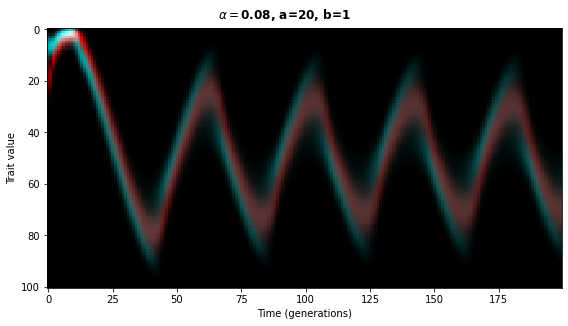

In [ ]:
#@title Diffuse trajectories
mat1= (v_s1[...,0].T)
mat2= (v_s2[...,0].T)

temp_max=np.max((mat1,mat2))
temp_min=np.min((mat1,mat2))

G_r = rescale(mat1, temp_min,temp_max) #clip?
R_r = rescale(mat2, temp_min,temp_max)

cmapgrn = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black", "cyan"]) #seagreen also
cmapred = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black", "red"])

blended1=blend(image1 = G_r,
               image2 = R_r,
               cmap1 = cmapgrn,
               cmap2 = cmapred)

temp_g = 1.2
blended2=blend(image1 = cNorm(G_r,temp_g),
               image2 = cNorm(R_r,temp_g),
               cmap1 = cmapgrn,
               cmap2 = cmapred)


fig = plt.figure(figsize=(8,6)); ax = fig.add_subplot(111)
pos = ax.imshow(blended2,interpolation='None')
fig.suptitle(r'$\alpha=$'+str(alpha)+', a='+str(a)+', b='+str(b),fontweight='bold',y=0.85)
ax.set_ylabel('Trait value')
ax.set_xlabel('Time (generations)')
plt.tight_layout()
plt.show()

In [ ]:
#@title Animation generation
fig = plt.figure(figsize=(8,6)); ax = fig.add_subplot(111)
div = make_axes_locatable(ax)
#cax = div.append_axes('right', '5%', '5%')
def frame(t):
    ax.clear()
    #plot=ax.imshow(l_matrix[:,:,w].astype('float32'), interpolation='none', cmap=my_cmap,vmax=1,vmin=10e-20,norm=LogNorm(vmin=0, vmax=1)) #
    ax.set_ylim(0,0.2)
    plot=ax.bar(np.arange(nstates),v_s1[t,:,0],width=1,alpha=0.5,color='cyan')
    plot+=ax.bar(np.arange(nstates),v_s2[t,:,0],width=1,alpha=0.5,color='red')
    #fig.colorbar(plot,ax=ax,cax=cax)
    return plot

anim = animation.FuncAnimation(fig, frame, frames=200, blit=False, repeat=True)

The animation below shows the change of the trait distribution of the resource species (cyan) and the exploiter species (red). Use the buttons for playing it, and **+** and **-** to change the speed.

In [ ]:
anim